In [365]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from optbinning import BinningProcess 
from optbinning import OptimalBinning

# auto binning

Below is the first iteration. Leverage autobinning by `optbinning` package so we can fit and transform a dataframe with both bin_features and num_features to scale. 

In [366]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings

    def fit(self, X, y=None):
        if self.bin_features:
            self.binning_process = {}
            for feature_name in self.bin_features:
                binning_process = BinningProcess(variable_names=[feature_name])
                binning_process.fit(X[feature_name].to_frame(), y)
                self.binning_process[feature_name] = binning_process

        if self.num_features:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.num_features])

        return self

    def transform(self, X):
        X_transformed = X.copy()

        if self.bin_features:
            for feature_name in self.bin_features:
                binned_data = self.binning_process[feature_name].transform(X[feature_name].to_frame())
                X_transformed[feature_name] = binned_data

        if self.num_features:
            scaled_data = self.scaler.transform(X[self.num_features])
            scaled_df = pd.DataFrame(scaled_data, columns=self.num_features, index=X.index)
            X_transformed[self.num_features] = scaled_df

        return X_transformed 

    def fit_transform(self, X, y=None):
        self.fit(X,y)
        return self.transform(X)   


In [367]:
n_feature = 5
n_inform = 5
n_redundant = 0
n_bin = 3
X, y = make_classification(n_samples = 1000, n_features = n_feature, n_informative = n_inform, n_redundant=n_redundant)

bin_features = [f'bin_{i+1}' for i in range(n_bin)]
num_features = [f'num_{n_bin+i+1}' for i in range(n_feature-n_bin)]
X = pd.DataFrame(X, columns = bin_features + num_features)


In [368]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
)

In [369]:
custom_transformer.fit(X,y)

CustomTransformer(bin_features=['bin_1', 'bin_2', 'bin_3'],
                  num_features=['num_4', 'num_5'])

In [370]:
X_transformed = custom_transformer.transform(X.copy())

In [371]:
X.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,-0.556059,-2.654193,-1.864880,1.265079,1.287403
1,-2.632033,1.437111,2.057680,-4.353668,-1.674179
2,1.467231,-1.969039,0.228547,-0.411211,1.055892
3,0.698461,0.156088,-2.454652,2.326295,1.921178
4,0.928814,-1.603388,-0.027093,0.597010,0.368074


In [372]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,-0.211501,-3.194746,1.869718,0.769510,0.529186
1,-2.389895,1.017000,-2.102213,-2.677289,-1.458495
2,0.259314,-3.194746,-0.332326,-0.258804,0.373806
3,0.167065,0.201244,1.869718,1.420508,0.954547
4,0.259314,-2.743535,-0.332326,0.359686,-0.087827


In [373]:
custom_transformer.fit_transform(X,y)

,bin_1,bin_2,bin_3,num_4,num_5
0,-0.211501,-3.194746,1.869718,0.769510,0.529186
1,-2.389895,1.017000,-2.102213,-2.677289,-1.458495
2,0.259314,-3.194746,-0.332326,-0.258804,0.373806
3,0.167065,0.201244,1.869718,1.420508,0.954547
4,0.259314,-2.743535,-0.332326,0.359686,-0.087827
...,...,...,...,...,...
995,-2.389895,-3.194746,-1.532445,-2.169975,-2.540120
996,-0.211501,0.201244,-2.102213,-1.538890,-0.488763
997,-0.211501,-3.194746,-0.332326,1.182297,-1.159261
998,0.259314,0.201244,-2.102213,0.265564,-0.068313


In [374]:
custom_transformer.binning_process.get('bin_1')

BinningProcess(variable_names=['bin_1'])

# next step: Add customized settings

We should be able to define special code and other configurations for each bin_feature. Below is a demo of how that can be done using `OptimalBinning`. 

## Toy Example

In [375]:
# Example data
data = pd.DataFrame({'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
target = [1,0,0,0,0,1,1,0,1,1]

# Define predefined split points for feature1
predefined_splits = [3, 8]
special_codes = [999,9999]

# Create an OptimalBinning instance with specific configurations
optb = OptimalBinning(name='feature1', 
                      user_splits=predefined_splits,
                      special_codes=special_codes,
                      dtype='numerical',
                      monotonic_trend='auto'
                      )

# Fit and transform the binning model to your data
optb.fit(data['feature1'], target) 
binning_table = optb.binning_table
table_built = binning_table.build()
binned_data = optb.transform(data['feature1'])

# Print the binned data
print("Binning table: \n", table_built)
print("Binned data: \n", binned_data)


Binning table: 
                  Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 3.00)      2        0.2          1      1    0.500000   
1       [3.00, 8.00)      5        0.5          3      2    0.400000   
2        [8.00, inf)      3        0.3          1      2    0.666667   
3            Special      0        0.0          0      0    0.000000   
4            Missing      0        0.0          0      0    0.000000   
Totals                   10        1.0          5      5    0.500000   

             WoE        IV        JS  
0            0.0  0.000000  0.000000  
1       0.405465  0.081093  0.010068  
2      -0.693147  0.138629  0.016990  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.219722  0.027058  
Binned data: 
 [ 0.          0.          0.40546511  0.40546511  0.40546511  0.40546511
  0.40546511 -0.69314718 -0.69314718 -0.69314718]


## Utilized in our demo data

Similarly, we can prepare specific configurations for each feature and pass that to our custom class.

In [376]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.scaler = None

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model

        if self.num_features:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.num_features])

        return self

    def transform(self, X):
        X_transformed = X.copy()

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name)
                if binning_model:
                    X_transformed[feature_name] = binning_model.transform(X[feature_name])

        if self.num_features:
            scaled_data = self.scaler.transform(X[self.num_features])
            scaled_df = pd.DataFrame(scaled_data, columns=self.num_features, index=X.index)
            X_transformed[self.num_features] = scaled_df

        return X_transformed


In [377]:
binning_settings = {
    'bin_1': {
            'dtype': 'numerical',
            'monotonic_trend': 'auto',
            'user_splits': [-0.5, 0, 0.5],
            'special_codes': [99,999]
              }
   ,'bin_2': {'dtype': 'numerical',
              'monotonic_trend': 'ascending',
              'user_splits': None,
              }
   ,'bin_3': {}
}

In [378]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    binning_settings=binning_settings    
)

In [379]:
custom_transformer.fit(X,y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {}


CustomTransformer(bin_features=['bin_1', 'bin_2', 'bin_3'],
                  binning_settings={'bin_1': {'dtype': 'numerical',
                                              'monotonic_trend': 'auto',
                                              'special_codes': [99, 999],
                                              'user_splits': [-0.5, 0, 0.5]},
                                    'bin_2': {'dtype': 'numerical',
                                              'monotonic_trend': 'ascending',
                                              'user_splits': None},
                                    'bin_3': {}},
                  num_features=['num_4', 'num_5'])

In [380]:
X_transformed = custom_transformer.transform(X.copy())

In [381]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,-0.988830,0.0,1.524348,0.769510,0.529186
1,-0.988830,0.0,-2.102213,-2.677289,-1.458495
2,0.425849,0.0,-0.332326,-0.258804,0.373806
3,0.425849,0.0,1.823290,1.420508,0.954547
4,0.425849,0.0,-0.332326,0.359686,-0.087827


# Add categorical variables

Next step, let's add a bit more complexity, let's add categorical variables.

To bin a categorical variable doesn't change the shape of transformed data and is relatively simple (see bin_3). Let's also treat one of the categorial feature (see cat_5) the traditional way, OneHotEncoding, which will change the shape and post a small challenge to ensure all columns in the transformed data should have meaningful name.

### Firs iteration

Wrap what we do for num_features into a num_transformer. The same will then be done for cat_features. 

use a num_transformer/cat_transformer wrapper have several benefits
* multiple steps may be taken for each data type, wrapping them together for easy update and maintainance
* the same function may be utilized to treat num and cat features, say SimpleImputer()

In [382]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.binning_tables = {}
        self.num_transformer = None

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name)
                if binning_model:
                    X_transformed[feature_name] = binning_model.transform(X[feature_name])

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            # transformed_num_data = pd.DataFrame(transformed_num_data, columns=self.num_features, index=X.index)
            X_transformed[self.num_features] = transformed_num_data

        return X_transformed

In [383]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    binning_settings=binning_settings    
)

In [384]:
custom_transformer.fit(X,y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {}


CustomTransformer(bin_features=['bin_1', 'bin_2', 'bin_3'],
                  binning_settings={'bin_1': {'dtype': 'numerical',
                                              'monotonic_trend': 'auto',
                                              'special_codes': [99, 999],
                                              'user_splits': [-0.5, 0, 0.5]},
                                    'bin_2': {'dtype': 'numerical',
                                              'monotonic_trend': 'ascending',
                                              'user_splits': None},
                                    'bin_3': {}},
                  num_features=['num_4', 'num_5'])

In [385]:
transformed_X = custom_transformer.transform(X.copy())

In [386]:
transformed_X

,bin_1,bin_2,bin_3,num_4,num_5
0,-0.988830,0.0,1.524348,0.769510,0.529186
1,-0.988830,0.0,-2.102213,-2.677289,-1.458495
2,0.425849,0.0,-0.332326,-0.258804,0.373806
3,0.425849,0.0,1.823290,1.420508,0.954547
4,0.425849,0.0,-0.332326,0.359686,-0.087827
...,...,...,...,...,...
995,-0.988830,0.0,-1.532445,-2.169975,-2.540120
996,-0.049158,0.0,-2.102213,-1.538890,-0.488763
997,-0.102001,0.0,-0.332326,1.182297,-1.159261
998,0.425849,0.0,-2.102213,0.265564,-0.068313


### Second Iteration. Categorical Features to Bin

This step is effortless: Just update the binning_settings, then we are done. :)

But to add a little bit of fun, I added binning_tables attribute to our class which will help us to see more details on how each features are binned and create visuals based on it. 

In [387]:
X_ = X.copy()
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['bottom', 'lower-mid', 'upper-mid', 'top']
labels_ = ['a', 'b', 'c', 'd']
X_['bin_3'] = pd.qcut(X_['bin_3'], q=percentiles, labels=labels)


In [388]:
binning_settings['bin_3'] = {'dtype': 'categorical',
                             'monotonic': 'auto',
                             'user_splits': None}

In [389]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.binning_tables = {}
        self.num_transformer = None

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model
                self.binning_tables[feature_name] = binning_model.binning_table

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])
            # self.scaler = StandardScaler()
            self.num_transformer.fit(X[self.num_features])

        return self

    def transform(self, X):
        X_transformed = pd.DataFrame()
        X_transformed.index = X.index

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name)
                if binning_model:
                    X_transformed[feature_name] = binning_model.transform(X[feature_name])

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data

        return X_transformed
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [390]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    binning_settings=binning_settings 
)

In [391]:
X_transformed = custom_transformer.fit_transform(X_, y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {'dtype': 'categorical', 'monotonic': 'auto', 'user_splits': None}


In [392]:
custom_transformer.binning_tables['bin_3'].build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[bottom],100,0.1,90,10,0.1000,2.205225,0.354606,0.037083
1,[lower-mid],400,0.4,296,104,0.2600,1.053969,0.408103,0.048776
2,[upper-mid],400,0.4,105,295,0.7375,-1.025015,0.386232,0.046271
3,[top],100,0.1,7,93,0.9300,-2.578689,0.441479,0.043666
4,Special,0,0.0,0,0,0.0000,0.0,0.000000,0.000000
5,Missing,0,0.0,0,0,0.0000,0.0,0.000000,0.000000
Totals,,1000,1.0,498,502,0.5020,,1.590419,0.175795


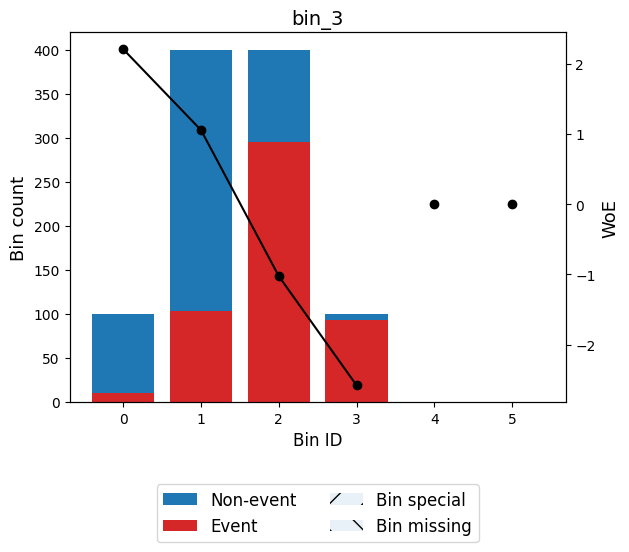

In [393]:
custom_transformer.binning_tables['bin_3'].plot()

In [394]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,-0.988830,0.0,1.053969,0.769510,0.529186
1,-0.988830,0.0,-1.025015,-2.677289,-1.458495
2,0.425849,0.0,-1.025015,-0.258804,0.373806
3,0.425849,0.0,2.205225,1.420508,0.954547
4,0.425849,0.0,1.053969,0.359686,-0.087827


## Iteration 3: Add Categorical Features

In [395]:
# update data and settings
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['D', 'C', 'B', 'A']
X2 = X_.copy()
X2['cat_5'] = pd.qcut(X2['num_5'], q=percentiles, labels=labels)
X2.drop('num_5', axis = 1, inplace = True)

num_features=['num_4']
cat_features=['cat_5']

In [396]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, 
                 cat_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.cat_features = cat_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.binning_tables = {}
        self.num_transformer = None
        self.cat_transformer = None
        self.transformed_cat_cols = []

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model
                self.binning_tables[feature_name] = binning_model.binning_table

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy = 'median'))
            ])
            self.num_transformer.fit(X[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps = [
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X[self.cat_features])
        
        return self
    
    def get_transformed_cat_cols(self):
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols
        
    
    def transform(self, X):
        X_transformed = pd.DataFrame()

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name, None)
                X_transformed[feature_name] = binning_model.transform(X[feature_name])


        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data,
                                            columns = self.transformed_cat_cols)
        
        X_transformed = pd.concat([X_transformed,transformed_cat_df], axis=1)
        X_transformed.index = X.index

        return X_transformed
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [397]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    cat_features=cat_features,
    binning_settings=binning_settings 
)

In [398]:
X_transformed = custom_transformer.fit_transform(X2,y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {'dtype': 'categorical', 'monotonic': 'auto', 'user_splits': None}


In [399]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,cat_5_A,cat_5_B,cat_5_C,cat_5_D
0,-0.988830,0.0,1.053969,0.769510,0.0,1.0,0.0,0.0
1,-0.988830,0.0,-1.025015,-2.677289,0.0,0.0,0.0,1.0
2,0.425849,0.0,-1.025015,-0.258804,0.0,1.0,0.0,0.0
3,0.425849,0.0,2.205225,1.420508,0.0,1.0,0.0,0.0
4,0.425849,0.0,1.053969,0.359686,0.0,0.0,1.0,0.0
